In [5]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import dolfin
import mesher

import pylab as p
import plotslopes

%matplotlib inline
plt.rcParams['figure.figsize']=(12, 8)

In [6]:
def exact_solution(degree,pars_ex):
    radius=1.
    pin=pars_ex['pin']
    pout=pars_ex['pout']
    nu=pars_ex['nu']
    rho = pars_ex['thickness']
    
    # Elasticity parameters
    E=dolfin.Constant(1.)
    mu = (E)/(2*(1.0+nu))
    
    p = (float(pin)+float(pout))/2.
    varpi = (float(pin)-float(pout))/p
    A = p*(1-2*float(nu))*(varpi/2./rho*(1+(rho/2)**2)-1)/2./float(mu)
    B = p*varpi*radius**2*((rho/2)**2-1)**2/8./(rho/2)/float(mu)
    
    r_ = dolfin.Expression("sqrt(pow(x[0], 2)+pow(x[1], 2))",degree=degree)
    theta_ = dolfin.Expression("atan2(x[1], x[0])",degree=degree)
    u_r_ref = dolfin.Expression("A*r+B/r",r=r_,A=A,B=B,degree=degree)
    u_ref = dolfin.Expression(("u*cos(theta)","u*sin(theta)"),
                          u=u_r_ref,theta=theta_,degree=degree)
    return u_ref

In [7]:
def fe_solution(ndiv,pars_fe):
    
    def eps(u):
        return dolfin.sym(dolfin.grad(u))
    
    def sig(epsilon):
        return 2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(ndim)
    
    def sig_devi(sigma):
        return sigma-((1./3.)*dolfin.tr(sigma)*dolfin.Identity(ndim))
    
    def sig_isot(sigma):
        return (1./3.)*dolfin.tr(sigma)*dolfin.Identity(ndim)
    r=1.
    h=pars_fe['thickness']/ndiv
    rho=pars_fe['thickness']/r
    nu = pars_fe['nu']
    pars = {"h": h, "rho": rho}
    
    meshname = mesher.generate_mesh_gmsh_tube("meshes/tube", pars)
    mesh = dolfin.Mesh(meshname + ".xml")
    boundaries = dolfin.MeshFunction("size_t", mesh, meshname + "_facet_region"+".xml")
    domains = dolfin.MeshFunction("size_t", mesh, meshname + "_physical_region"+".xml")

    dolfin.File(os.path.join(os.path.dirname(meshname), "boundaries.pvd")) << boundaries
    dolfin.File(os.path.join(os.path.dirname(meshname), "domains.pvd")) << domains

    with dolfin.XDMFFile(mesh.mpi_comm(), "output/boundaries.xdmf") as file: 
        file.write(boundaries)

    # Elasticity parameters
    E=dolfin.Constant(1.)

    mu = (E)/(2*(1.0+nu))
    lmbda = (E*nu)/((1.0+nu)*(1.0-2.0*nu))
    
    # Stress / Strain
    ndim = 2

    
    # Create element
    element = dolfin.VectorElement("P", dolfin.triangle, pars_fe['degree'], dim=2)
    #dim c'est dimension des inconnu nodale ux et uy

    # Create function space
    V = dolfin.FunctionSpace(mesh, element)

    # Create test and trial functions, and source term
    u_ = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # Define the bilinear form for the problem
    a = dolfin.inner(sig(eps(u_)), eps(v))*dolfin.dx 

    # Parameters
    p_out = dolfin.Constant(0.)
    p_in = dolfin.Constant(1.)
    ds = dolfin.Measure("ds", subdomain_data=boundaries)
    #ds element de surface mais ici prend boundaries en parametre
    #boundarises renvoi pour chaque élément 
    #1,2,3 ou 4 en fonction de son appartenance au bord
    n = dolfin.FacetNormal(mesh)

    # Weak formulation
    L = dolfin.inner(-p_in*n, v)*ds(4)+dolfin.inner(-p_out*n, v)*ds(2)

    bcs = [dolfin.DirichletBC(V.sub(0), 0., boundaries, 3),
           dolfin.DirichletBC(V.sub(1), 0., boundaries, 1)]

    # Set up PDE and solve
    u_num = dolfin.Function(V)
    problem = dolfin.LinearVariationalProblem(a, L, u_num, bcs)
    # solver
    solver = dolfin.LinearVariationalSolver(problem)
    #  define le solver ex: LU ou gradient
    solver.solve()
    pars_ex = {"thickness": 0.5, "nu": 0.3, "pin": 1., "pout": 0}
    u_exact= exact_solution(pars_fe['degree'],pars_ex)
    error_h1 = dolfin.errornorm(u_exact, u_num, norm_type = "H1")
    error_L2 = dolfin.errornorm(u_exact, u_num, norm_type = "L2")

    epsilon=eps(u_num)
    sigma=sig(epsilon)
    deviatoric=sig_devi(sigma)
    isotropic=sig_isot(sigma)
       
    return 1.0 / ndiv , error_h1 , error_L2



In [8]:
#exact_solution(1,pars_ex)
#pars_fe = {"thickness": 0.5, "degree": 1, "nu": 0.3}
#fe_solution(2,pars_fe)
#u_num, erreurh1, erreurL2 = fe_solution(1, pars_fe)

In [9]:
pars_ex= {"thickness": 0.5, "nu": 0.3, "pin": dolfin.Constant(1.), "pout": dolfin.Constant(0.)}
pars_fe_P1 = {"thickness": 0.5, "degree": 1, "nu": 0.3}
pars_fe_P2 = {"thickness": 0.5, "degree": 2, "nu": 0.3}
a_P1, erreurH1_P1, erreurL2_P1 = zip(*[fe_solution(n, pars_fe_P1) for n in [2, 4, 8,16]])
a_P2, erreurH1_P2, erreurL2_P2 = zip(*[fe_solution(n, pars_fe_P2) for n in [2, 4, 8,16]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/usr/lib/python3/dist-packages/matplotlib/__init__.py:806: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/lib/python3/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


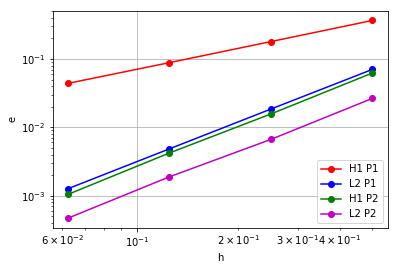

In [8]:
# Plot results
enable_plot = True

if enable_plot:
    p.hold(True)
    p.loglog(a_P1, erreurH1_P1, 'r-o')
    p.loglog(a_P1, erreurL2_P1, 'b-o')
    p.loglog(a_P2, erreurH1_P2, 'g-o')
    p.loglog(a_P2, erreurL2_P2, 'm-o')
    p.legend(["H1 P1", "L2 P1" ,"H1 P2","L2 P2"], loc="lower right")
    p.xlabel("h")
    p.ylabel("e")
    p.grid(True)
    p.show()

In [9]:
def eps(u):
        return dolfin.sym(dolfin.grad(u))
    
def sig(epsilon):
        return 2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(ndim)
    
def sig_devi(sigma):
        return sigma-((1./3.)*tr(sigma)*dolfin.Identity(ndim))

def sig_isot(sigma):
        return (1./3.)*tr(sigma)*dolfin.Identity(ndim)

In [10]:
pars_ex= {"thickness": 0.5, "nu": 0.48, "pin": dolfin.Constant(1.), "pout": dolfin.Constant(0.)}
pars_fe_P1 = {"thickness": 0.5, "degree": 1, "nu": 0.48}
pars_fe_P2 = {"thickness": 0.5, "degree": 2, "nu": 0.48}
a_P12, erreurH1_P12, erreurL2_P12 = zip(*[fe_solution(n, pars_fe_P1) for n in [2, 4, 8,16]])
a_P22, erreurH1_P22, erreurL2_P22 = zip(*[fe_solution(n, pars_fe_P2) for n in [2, 4, 8,16]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.


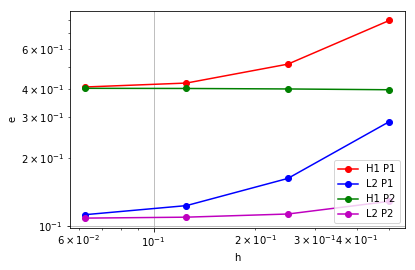

In [11]:
# Plot results
enable_plot = True
if enable_plot:
    p.hold(True)
    p.loglog(a_P12, erreurH1_P12, 'r-o')
    p.loglog(a_P12, erreurL2_P12, 'b-o')
    p.loglog(a_P22, erreurH1_P22, 'g-o')
    p.loglog(a_P22, erreurL2_P22, 'm-o')
    p.legend(["H1 P1", "L2 P1" ,"H1 P2","L2 P2"], loc="lower right")
    p.xlabel("h")
    p.ylabel("e")
    p.grid(True)
    p.show()

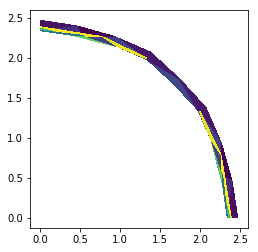

In [74]:
dolfin.plot(u_num1[0], mode = "displacement");

In [73]:
def fe_solution2(ndiv,pars_fe):
    
    def eps(u):
        return dolfin.sym(dolfin.grad(u))
    
    def sig(epsilon):
        return 2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(ndim)
    
    def sig_devi(sigma):
        return sigma-((1./3.)*dolfin.tr(sigma)*dolfin.Identity(ndim))
    
    def sig_isot(sigma):
        return (1./3.)*dolfin.tr(sigma)*dolfin.Identity(ndim)
    r=1.
    h=pars_fe['thickness']/ndiv
    rho=pars_fe['thickness']/r
    nu = pars_fe['nu']
    pars = {"h": h, "rho": rho}
    
    meshname = mesher.generate_mesh_gmsh_tube("meshes/tube", pars)
    mesh = dolfin.Mesh(meshname + ".xml")
    boundaries = dolfin.MeshFunction("size_t", mesh, meshname + "_facet_region"+".xml")
    domains = dolfin.MeshFunction("size_t", mesh, meshname + "_physical_region"+".xml")

    dolfin.File(os.path.join(os.path.dirname(meshname), "boundaries.pvd")) << boundaries
    dolfin.File(os.path.join(os.path.dirname(meshname), "domains.pvd")) << domains

    with dolfin.XDMFFile(mesh.mpi_comm(), "output/boundaries.xdmf") as file: 
        file.write(boundaries)

    # Elasticity parameters
    E=dolfin.Constant(1.)

    mu = (E)/(2*(1.0+nu))
    lmbda = (E*nu)/((1.0+nu)*(1.0-2.0*nu))
    
    # Stress / Strain
    ndim = 2

    
    # Create element
    element = dolfin.VectorElement("P", dolfin.triangle, pars_fe['degree'], dim=2)
    #dim c'est dimension des inconnu nodale ux et uy

    # Create function space
    V = dolfin.FunctionSpace(mesh, element)

    # Create test and trial functions, and source term
    u_ = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # Define the bilinear form for the problem
    a = dolfin.inner(sig(eps(u_)), eps(v))*dolfin.dx 

    # Parameters
    p_out = dolfin.Constant(0.)
    p_in = dolfin.Constant(1.)
    ds = dolfin.Measure("ds", subdomain_data=boundaries)
    #ds element de surface mais ici prend boundaries en parametre
    #boundarises renvoi pour chaque élément 
    #1,2,3 ou 4 en fonction de son appartenance au bord
    n = dolfin.FacetNormal(mesh)

    # Weak formulation
    L = dolfin.inner(-p_in*n, v)*ds(4)+dolfin.inner(-p_out*n, v)*ds(2)

    bcs = [dolfin.DirichletBC(V.sub(0), 0., boundaries, 3),
           dolfin.DirichletBC(V.sub(1), 0., boundaries, 1)]

    # Set up PDE and solve
    u_num = dolfin.Function(V)
    problem = dolfin.LinearVariationalProblem(a, L, u_num, bcs)
    # solver
    solver = dolfin.LinearVariationalSolver(problem)
    #  define le solver ex: LU ou gradient
    solver.solve()
    pars_ex = {"thickness": 0.5, "nu": 0.3, "pin": 1., "pout": 0}
    u_exact= exact_solution(pars_fe['degree'],pars_ex)
    error_h1 = dolfin.errornorm(u_exact, u_num, norm_type = "H1")
    error_L2 = dolfin.errornorm(u_exact, u_num, norm_type = "L2")

    epsilon=eps(u_num)
    sigma=sig(epsilon)
    deviatoric=sig_devi(sigma)
    isotropic=sig_isot(sigma)
    T = dolfin.TensorFunctionSpace(mesh, 'CG', 1)
       
    return 1.0 / ndiv , error_h1 , error_L2, epsilon,sigma,u_num ,T, mesh

In [74]:
pars_fe = {"thickness": 0.5, "degree": 1, "nu": 0.3}
a_P12, erreurH1_P12, erreurL2_P12,epsilon,sigma,u_num,T,mesh = zip(*[fe_solution2(n, pars_fe_P1) for n in [4]])

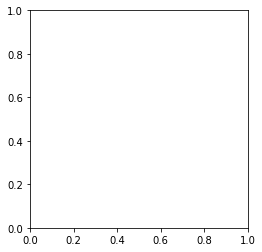

In [69]:
dolfin.plot(0.1*epsilon[0], mode = "strain");

In [68]:
stress = dolfin.project(sigma[0],T)
File("stress.pvd") << stress
M = stress.vector().array()
print(M) 

AttributeError: 'tuple' object has no attribute 'mesh'

In [86]:
nz = dolfin.Constant((0, 1))
surface_traction_top = dolfin.project(dolfin.dot(sigma[0],nz), dolfin.VectorFunctionSpace(mesh,'DG',1))
surface_traction_top_normal = dolfin.project(dolfin.dot(dolfin.dot(sigma[0],nz),nz), dolfin.FunctionSpace(mesh,'DG',1))

AttributeError: 'tuple' object has no attribute 'ufl_cell'

In [54]:
def fe_solution_mixte(ndiv,pars_fe):
    
    # Test for PETSc or Tpetra
    if not dolfin.has_linear_algebra_backend("PETSc") and not has_linear_algebra_backend("Tpetra"):
        info("DOLFIN has not been configured with Trilinos or PETSc. Exiting.")
        exit()

    if not dolfin.has_krylov_solver_preconditioner("amg"):
        info("Sorry, this demo is only available when DOLFIN is compiled with AMG "
         "preconditioner, Hypre or ML.")
        exit()

    if dolfin.has_krylov_solver_method("minres"):
        krylov_method = "minres"
    elif has_krylov_solver_method("tfqmr"):
        krylov_method = "tfqmr"
    else:
        info("Default linear algebra backend was not compiled with MINRES or TFQMR "
         "Krylov subspace method. Terminating.")
        exit()
    
    def eps(u):
        return dolfin.sym(dolfin.grad(u))
    
    def sig(epsilon):
        return 2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(ndim)
    
    def sig_devi(sigma):
        return sigma-((1./3.)*dolfin.tr(sigma)*dolfin.Identity(ndim))
    
    def sig_isot(sigma):
        return (1./3.)*dolfin.tr(sigma)*dolfin.Identity(ndim)
    r=1.
    h=pars_fe['thickness']/ndiv
    rho=pars_fe['thickness']/r
    nu = pars_fe['nu']
    pars = {"h": h, "rho": rho}
    
    meshname = mesher.generate_mesh_gmsh_tube("meshes/tube", pars)
    mesh = dolfin.Mesh(meshname + ".xml")
    boundaries = dolfin.MeshFunction("size_t", mesh, meshname + "_facet_region"+".xml")
    domains = dolfin.MeshFunction("size_t", mesh, meshname + "_physical_region"+".xml")

    dolfin.File(os.path.join(os.path.dirname(meshname), "boundaries.pvd")) << boundaries
    dolfin.File(os.path.join(os.path.dirname(meshname), "domains.pvd")) << domains

    with dolfin.XDMFFile(mesh.mpi_comm(), "output/boundaries.xdmf") as file: 
        file.write(boundaries)

    # Elasticity parameters
    E=dolfin.Constant(1.)

    mu = (E)/(2*(1.0+nu))
    lmbda = (E*nu)/((1.0+nu)*(1.0-2.0*nu))
    
    # Stress / Strain
    ndim = 2

    
    # Create element
    element = dolfin.VectorElement("P", dolfin.triangle, pars_fe['degree'], dim=2)
    #dim c'est dimension des inconnu nodale ux et uy

    # Create function space
    V = dolfin.FunctionSpace(mesh, element)
    P2 = dolfin.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    P1 = dolfin.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    TH = P2 * P1
    W = dolfin.FunctionSpace(mesh, TH)
    
    #element = dolfin.VectorElement("P", dolfin.triangle, pars_fe['degree'], dim=2)
    #W = dolfin.FunctionSpace(mesh, element)
    
    # Create test and trial functions, and source term
    #u_ = dolfin.TrialFunction(V)
    #v = dolfin.TestFunction(V)
    
    f = dolfin.Constant((0.0, 0.0))
        
    (u_, p) = dolfin.TrialFunctions(W)
    (v, q) = dolfin.TestFunctions(W)
    a = dolfin.inner(sig(eps(u_)), eps(v))*dolfin.dx 
    L = dolfin.inner(f, v)*dolfin.dx


    # Define the bilinear form for the problem
    #a = dolfin.inner(sig(eps(u_)), eps(v))*dolfin.dx 

    # Parameters
    p_out = dolfin.Constant(0.)
    p_in = dolfin.Constant(1.)
    ds = dolfin.Measure("ds", subdomain_data=boundaries)
    #ds element de surface mais ici prend boundaries en parametre
    #boundarises renvoi pour chaque élément 
    #1,2,3 ou 4 en fonction de son appartenance au bord
    n = dolfin.FacetNormal(mesh)

    # Weak formulation
    L = dolfin.inner(-p_in*n, v)*ds(4)+dolfin.inner(-p_out*n, v)*ds(2)

    bcs = [dolfin.DirichletBC(W.sub(0), 0., boundaries, 3),
           dolfin.DirichletBC(W.sub(1), 0., boundaries, 1)]
    
    b = dolfin.inner(dolfin.grad(u_), dolfin.grad(v))*dolfin.dx + p*q*dolfin.dx
    
    A, bb = dolfin.assemble_system(a, L, bcs)
    P, btmp = dolfin.assemble_system(b, L, bcs)
    
    solver = dolfin.KrylovSolver(krylov_method, "amg")
    solver.set_operators(A, P)
    u_num = dolfin.Function(W)
    solver.solve(u_num.vector(), bb)

    # Set up PDE and solve
    #u_num = dolfin.Function(V)
    #problem = dolfin.LinearVariationalProblem(a, L, u_num, bcs)
    # solver
    #solver = dolfin.LinearVariationalSolver(problem)
    #  define le solver ex: LU ou gradient
    #solver.solve()
    #pars_ex = {"thickness": 0.5, "nu": 0.3, "pin": 1., "pout": 0}
    #u_exact= exact_solution(pars_fe['degree'],pars_ex)
    #error_h1 = dolfin.errornorm(u_exact, u_num, norm_type = "H1")
    #error_L2 = dolfin.errornorm(u_exact, u_num, norm_type = "L2")

    return 1.0 / ndiv , error_h1 , error_L2


In [55]:
pars_fe = {"thickness": 0.5, "degree": 1, "nu": 0.3}
a_P22, erreurH1_P22, erreurL2_P22 = zip(*[fe_solution_mixte(n, pars_fe) for n in [2]])

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to create Dirichlet boundary condition.
*** Reason:  Expecting a vector-valued boundary value but given function is scalar.
*** Where:   This error was encountered inside DirichletBC.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2018.1.0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------
